## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from neural_network_helper import MLPModel, SurvivalDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data and Preprocessing

In [45]:
required_attributes = {
    "primary_diagnosis",
    "case_id",
    "age_at_diagnosis",
    "gender",
    "race",
    "ethnicity",
    "age_at_index",
    "ajcc_pathologic_stage",
    "prior_malignancy",
    "prior_treatment",
    "classification_of_tumor",
    "metastasis_at_diagnosis",
    "tumor_grade",
    "progression_or_recurrence",
    "alcohol_history",
    "cigarettes_per_day",
    "years_smoked",
    "vital_status",
    "days_to_diagnosis",
    "days_to_last_follow_up",
    "days_to_treatment_start",
    "days_to_treatment_end",
    "days_to_recurrence",
    "days_to_death"
}

df = pd.read_csv("clinical_data_extracted.csv")

# Select only required attributes that exist in the dataset
df = df[list(required_attributes & set(df.columns))]

In [46]:
target = "days_to_death"

# Drop rows where the target is missing
df = df.dropna(subset=[target])

# Separate features into different types for feature engineering

numerical_features = [
    "age_at_diagnosis", "age_at_index", "days_to_last_follow_up",
    "days_to_diagnosis", "days_to_treatment_start", "days_to_treatment_end", "days_to_recurrence", "cigarettes_per_day", "years_smoked"
]

# Features with arbitrary labels that can be one-hot encoded
categorical_label_features = [
    "primary_diagnosis", "classification_of_tumor", "gender", "race",
    "ethnicity", "prior_malignancy", "prior_treatment",
    "metastasis_at_diagnosis", "progression_or_recurrence", "alcohol_history"
]

categorical_order_features = [
    "tumor_grade", "ajcc_pathologic_stage"
]

# Remove columns that don't exist in dataframe
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_label_features = [col for col in categorical_label_features if col in df.columns]
categorical_order_features = [col for col in categorical_order_features if col in df.columns]

# Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing numerical values with mean
    ('scaler', RobustScaler())  # Normalize numerical data using RobustScaler for outliers
])

cat_label_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),  # Fill missing categorical values with Unknown since not being
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical to one hot encoded vectors
])

cat_order_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),  # Fill missing orderly categorical values with Unknown
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Use ordinal encoding because tumor grades have levels
])

# Combine all the pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat_label', cat_label_pipeline, categorical_label_features),
    ('cat_order', cat_order_pipeline, categorical_order_features)
])

In [47]:
X = df[numerical_features + categorical_label_features + categorical_order_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessor from above to the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Convert to PyTorch tensors for further operation
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create the train and test datasets
train_dataset = SurvivalDataset(X_train_tensor, y_train_tensor)
test_dataset = SurvivalDataset(X_test_tensor, y_test_tensor)

# Create DataLoader with batch_size=64
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 3. Model with SGD optimizer

In [48]:
# Initialize the model
input_dim = X_train_tensor.shape[1]
model = MLPModel(input_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop with validation loss calculation
num_epochs = 1000
train_losses = []
val_losses = []

### 3.1 Training

In [49]:
# Move the model to the selected device (GPU or CPU)
model = model.to(device)

for epoch in range(num_epochs):
    model.train()

    # Training Phase
    running_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the same device as the model
        data, targets = data.to(device), targets.to(device)

        # Forward pass (Training data)
        outputs = model(data)
        train_loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Total training loss
        running_train_loss += train_loss.item()

    # Average training loss for the epoch
    train_losses.append(running_train_loss / len(train_loader))

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data and targets to the same device as the model
            data, targets = data.to(device), targets.to(device)
            
            val_outputs = model(data)
            val_loss = criterion(val_outputs, targets)
            running_val_loss += val_loss.item()

    # Average validation loss for the epoch
    val_losses.append(running_val_loss / len(test_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch [10/1000], Train Loss: 492609.2934, Val Loss: 512869.3787
Epoch [20/1000], Train Loss: 493833.2161, Val Loss: 482199.1734
Epoch [30/1000], Train Loss: 464830.8088, Val Loss: 455971.6972
Epoch [40/1000], Train Loss: 447227.8239, Val Loss: 461580.5729
Epoch [50/1000], Train Loss: 450655.7116, Val Loss: 446582.6488
Epoch [60/1000], Train Loss: 439035.9389, Val Loss: 419937.0997
Epoch [70/1000], Train Loss: 440782.5179, Val Loss: 457269.1525
Epoch [80/1000], Train Loss: 425776.8256, Val Loss: 444068.5112
Epoch [90/1000], Train Loss: 430543.6543, Val Loss: 428828.0365
Epoch [100/1000], Train Loss: 433760.4211, Val Loss: 432855.5774
Epoch [110/1000], Train Loss: 438539.7787, Val Loss: 431946.0446
Epoch [120/1000], Train Loss: 426493.8447, Val Loss: 446805.2716
Epoch [130/1000], Train Loss: 421746.4701, Val Loss: 419671.0290
Epoch [140/1000], Train Loss: 438351.1516, Val Loss: 410317.1882
Epoch [150/1000], Train Loss: 422304.3883, Val Loss: 413420.7530
Epoch [160/1000], Train Loss: 4288

### 3.2 Performance Metric

In [50]:
# Set model to evaluation mode
model.eval()
model = model.to(device)

y_pred = []
with torch.no_grad():
    for data in test_loader:
        # Move input data to the same device as the model
        data = data[0].to(device)  # Assuming data[0] is the input
        
        # Predict using the model
        y_pred_batch = model(data)
        y_pred.append(y_pred_batch)

# Concatenate the predictions into a single tensor and flatten it
y_pred = torch.cat(y_pred, dim=0).flatten()


In [51]:
# Compute Metric Scores
y_pred = y_pred.cpu().numpy()

# Now you can compute the metrics using y_pred_cpu
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Evaluation:\nRMSE: {rmse:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}\nR² Score: {r2:.3f}")

Model Evaluation:
RMSE: 640.760
MSE: 410573.128
MAE: 405.565
R² Score: 0.392


### 3.3 Plots

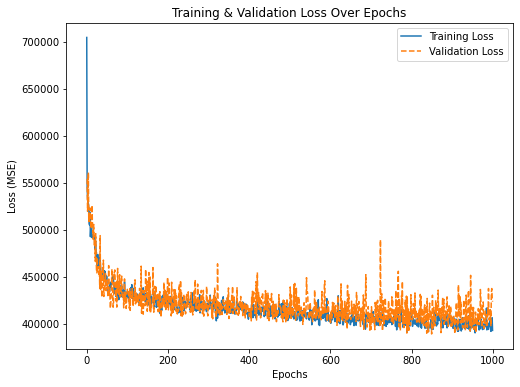

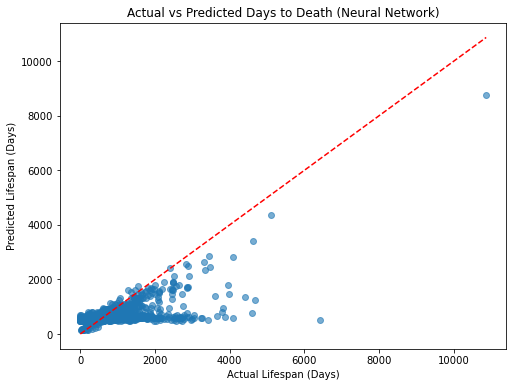

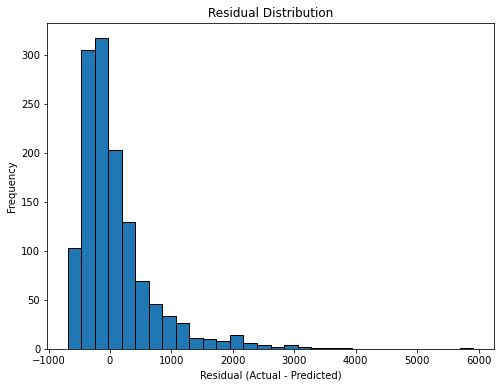

In [52]:
# Plot the training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training & Validation Loss Over Epochs")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("Actual Lifespan (Days)")
plt.ylabel("Predicted Lifespan (Days)")
plt.title("Actual vs Predicted Days to Death (Neural Network)")
plt.show()

# Ensure both y_test and y_pred are PyTorch tensors
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Calculate residuals (difference between actual and predicted values)
residuals = y_test_tensor.flatten() - y_pred

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals.numpy(), bins=30, edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Top 10 Most Important Features:
num__days_to_diagnosis                                      2775.210449
num__days_to_recurrence                                     1121.764893
cat_order__ajcc_pathologic_stage                            1071.700684
num__days_to_treatment_start                                1031.426270
num__days_to_treatment_end                                   957.266296
num__days_to_last_follow_up                                  897.201660
cat_order__tumor_grade                                       858.634705
cat_label__primary_diagnosis_Acute myeloid leukemia, NOS     627.086365
num__age_at_index                                            559.790588
num__age_at_diagnosis                                        553.348633
dtype: float32


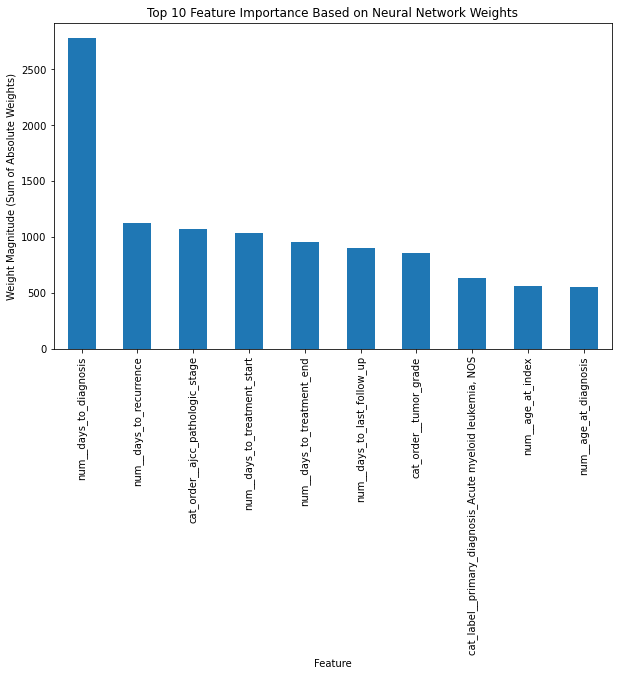

In [53]:
# Function to get feature importance based on the model weights
def get_feature_importance(model):
    # Extract the weights from the first layer
    weights = model.fc1.weight.data.cpu().numpy()
    # Compute the importance based on the sum of absolute weights for each feature
    feature_importance = np.abs(weights).sum(axis=0)
    return feature_importance

feature_importance = get_feature_importance(model)
feature_names = preprocessor.get_feature_names_out()


if len(feature_importance) != len(feature_names):
    print(f"Warning: Length mismatch between feature importance ({len(feature_importance)}) and feature names ({len(feature_names)})")


feature_importance_series = pd.Series(feature_importance, index=feature_names)

top_10_features = feature_importance_series.sort_values(ascending=False).head(10)
print("Top 10 Most Important Features:")
print(top_10_features)

# Plot the top 10 features' importance
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.xlabel("Feature")
plt.ylabel("Weight Magnitude (Sum of Absolute Weights)")
plt.title("Top 10 Feature Importance Based on Neural Network Weights")
plt.show()


## 4. Model with Adam optimizer

In [54]:
# Initialize the model
input_dim = X_train_tensor.shape[1]
model = MLPModel(input_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

# Training loop with validation loss calculation
num_epochs = 1000
train_losses = []
val_losses = []

### 4.1 Training

In [55]:
# Move the model to the device
model = model.to(device)

for epoch in range(num_epochs):
    model.train()

    # Training Phase
    running_train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the same device as the model
        data, targets = data.to(device), targets.to(device)

        # Forward pass (Training data)
        outputs = model(data)
        train_loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Total training loss
        running_train_loss += train_loss.item()

    # Average training loss for the epoch
    train_losses.append(running_train_loss / len(train_loader))

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            # Move data and targets to the same device as the model
            data, targets = data.to(device), targets.to(device)
            
            val_outputs = model(data)
            val_loss = criterion(val_outputs, targets)
            running_val_loss += val_loss.item()

    # Average validation loss for the epoch
    val_losses.append(running_val_loss / len(test_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch [10/1000], Train Loss: 408012.7432, Val Loss: 373772.0074
Epoch [20/1000], Train Loss: 391192.6472, Val Loss: 369799.7679
Epoch [30/1000], Train Loss: 382939.3445, Val Loss: 368708.5365
Epoch [40/1000], Train Loss: 361006.5434, Val Loss: 370280.9182
Epoch [50/1000], Train Loss: 364006.9299, Val Loss: 364694.6243
Epoch [60/1000], Train Loss: 350457.1161, Val Loss: 372566.9784
Epoch [70/1000], Train Loss: 365619.7953, Val Loss: 381192.9985
Epoch [80/1000], Train Loss: 355382.9292, Val Loss: 352156.7515
Epoch [90/1000], Train Loss: 351804.2317, Val Loss: 370286.4926
Epoch [100/1000], Train Loss: 349932.3935, Val Loss: 370125.2932
Epoch [110/1000], Train Loss: 348464.6225, Val Loss: 343621.1365
Epoch [120/1000], Train Loss: 340065.1507, Val Loss: 356391.3274
Epoch [130/1000], Train Loss: 342390.8354, Val Loss: 358472.1868
Epoch [140/1000], Train Loss: 334094.8488, Val Loss: 363142.5930
Epoch [150/1000], Train Loss: 342039.9473, Val Loss: 353082.8981
Epoch [160/1000], Train Loss: 3348

### 4.2 Performance Metric

In [56]:
# Predict on test data
model.eval()  # Set model to evaluation mode
model = model.to(device)
y_pred = []
with torch.no_grad():
    for data in test_loader:
        y_pred_batch = model(data[0].to(device))
        y_pred.append(y_pred_batch)

y_pred = torch.cat(y_pred, dim=0).flatten()

In [57]:
# Compute Metric Scores
y_pred = y_pred.cpu().numpy()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model Evaluation:\nRMSE: {rmse:.3f}\nMSE: {mse:.3f}\nMAE: {mae:.3f}\nR² Score: {r2:.3f}")

Model Evaluation:
RMSE: 593.695
MSE: 352473.574
MAE: 352.412
R² Score: 0.478


### 4.3 Plots

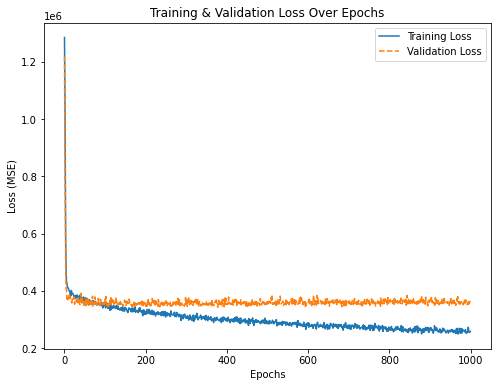

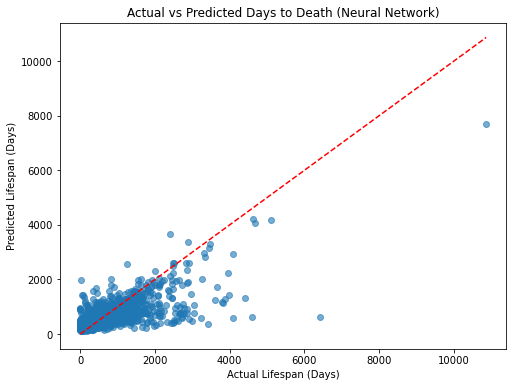

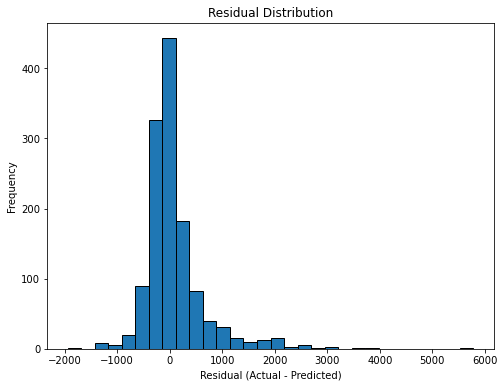

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training & Validation Loss Over Epochs")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel("Actual Lifespan (Days)")
plt.ylabel("Predicted Lifespan (Days)")
plt.title("Actual vs Predicted Days to Death (Neural Network)")
plt.show()

# Ensure both y_test and y_pred are PyTorch tensors
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Calculate residuals (difference between actual and predicted values)
residuals = y_test_tensor.flatten() - y_pred

# Plot Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals.numpy(), bins=30, edgecolor='black')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

Top 10 Most Important Features:
cat_label__primary_diagnosis_Thymoma, type B3, malignant                  3903.446777
cat_label__primary_diagnosis_Gastrointestinal stromal tumor, malignant    3864.381348
cat_label__primary_diagnosis_Medullary carcinoma, NOS                     3651.721191
cat_label__primary_diagnosis_Paraganglioma, NOS                           3087.453369
cat_label__primary_diagnosis_Diffuse large B-cell lymphoma, NOS           2800.367920
cat_label__progression_or_recurrence_No                                   2782.961914
cat_label__primary_diagnosis_Amelanotic melanoma                          2758.490479
cat_label__primary_diagnosis_Signet ring cell carcinoma                   2704.861084
cat_label__primary_diagnosis_Epithelioid cell melanoma                    2652.846924
cat_label__primary_diagnosis_Epithelioid mesothelioma, malignant          2604.374512
dtype: float32


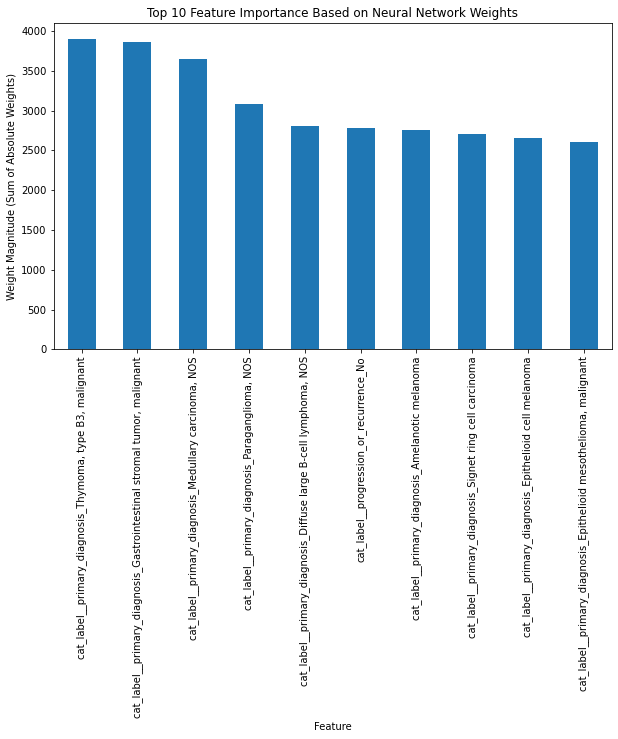

In [59]:
# Function to get feature importance based on the model weights
def get_feature_importance(model):
    # Extract the weights from the first layer
    weights = model.fc1.weight.data.cpu().numpy()
    # Compute the importance based on the sum of absolute weights for each feature
    feature_importance = np.abs(weights).sum(axis=0)
    return feature_importance

feature_importance = get_feature_importance(model)
feature_names = preprocessor.get_feature_names_out()


if len(feature_importance) != len(feature_names):
    print(f"Warning: Length mismatch between feature importance ({len(feature_importance)}) and feature names ({len(feature_names)})")


feature_importance_series = pd.Series(feature_importance, index=feature_names)

top_10_features = feature_importance_series.sort_values(ascending=False).head(10)
print("Top 10 Most Important Features:")
print(top_10_features)

# Plot the top 10 features' importance
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.xlabel("Feature")
plt.ylabel("Weight Magnitude (Sum of Absolute Weights)")
plt.title("Top 10 Feature Importance Based on Neural Network Weights")
plt.show()
